# Parametric DNN – Clean Version (Balanced Training Only)

parametrized DNN 
1. Plot signal and background seperation
2. Include all signals
2. check the backgrounds.
3. Check the AUC score as this is coming 1
4. Improve the training
5. include the weight of preselection
6. Weights for signal and background to negate the class imbalance
7. Plot the DNN score for each sample. 
8. Event categorization 
9. check all of the code and implementation of weights
10. Check model
    1. Check loss functions
11. fix the error. 
12. Check the imbalance of data in the signal and backgrounds.




In [1]:

import os
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam


In [2]:
mass_points = [300, 400, 500, 550, 600, 650, 700, 900, 1000]  #  mass points
y_values = [ 95, 100, 125, 150, 200, 300, 400, 500, 600, 800]  #  Y values



# Load signal data from Parquet files
signal_data = []
for mass in mass_points:
    for y in y_values:
        file_path = f"../../../output_parquet/final_production_Syst/merged/NMSSM_X{mass}_Y{y}/nominal/NOTAG_merged.parquet"
        
        if os.path.exists(file_path):  # Check if file exists
            try:
                df = pd.read_parquet(file_path)  # Load the Parquet file
                df["mass"] = mass  
                df["y_value"] = y  # Store Y value if needed
                df["label"] = 1  # Assuming signal label
                signal_data.append(df)
            except Exception as e:
                print(f"Warning: Could not read {file_path}. Error: {e}")
        else:
            print(f"Warning: File {file_path} does not exist.")

# Combine all signal data into a single DataFrame
signal_df = pd.concat(signal_data, ignore_index=True) if signal_data else pd.DataFrame()

In [3]:
signal_df.shape

(425191, 853)

In [4]:
# Load background data from ROOT files
background_files = [
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt20To40/preselection"),
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt40/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GGJets/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt20To40/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt40/preselection"),
]
background_data = []
for file_path, tree_name in background_files:
    try:
        with uproot.open(file_path) as file:
            tree = file[tree_name]
            df = tree.arrays(library="pd")
#             df["mass"] = np.random.choice(mass_points, len(df))  # Random mass assignment
            df["label"] = 0
            background_data.append(df)
    except Exception as e:
        print(f"Warning: Could not read {file_path}. Error: {e}")

df_background = pd.concat(background_data, ignore_index=True) if background_data else pd.DataFrame()
# Assigning random mass to Y
df_background["mass"] = np.random.choice(mass_points, size=len(df_background))
df_background["y_value"] = np.random.choice(y_values, size=len(df_background))


In [5]:
# Define features and labels
features = [
    # bbgg varaibles
    'bbgg_eta', 'bbgg_phi',
    # Photon variables
    'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi',
    # Diphoton variables
    'diphoton_eta', 'diphoton_phi',
    # dibjet variables
    'dibjet_eta', 'dibjet_phi', 
    # bjet kinematics
    'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 
    'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 
    # collion-sopper frame variables.
    'CosThetaStar_gg', 
    'CosThetaStar_jj', 'CosThetaStar_CS', 
    # Delta (jg, min)
    'DeltaR_jg_min',
    # Ratios
    'pholead_PtOverM', 'phosublead_PtOverM',
    # Pho mvaID
    'lead_pho_mvaID', 'sublead_pho_mvaID'
]
features.extend(["mass", "y_value"])


In [6]:
# Random mass + y_value assignment for backgrounds (ensure this was done earlier!)
# df_background["mass"] = np.random.choice(mass_points, len(df_background))
# df_background["y_value"] = np.random.choice(y_values, len(df_background))


# Sample (mass, y_value) pairs from signal and assign to background
# sampled_mass_y = signal_df[["mass", "y_value"]].sample(n=len(df_background), replace=True).reset_index(drop=True)
# df_background["mass"] = sampled_mass_y["mass"]
# df_background["y_value"] = sampled_mass_y["y_value"]

# Get signal distribution weights
signal_mass_y = signal_df[["mass", "y_value"]]
value_counts = signal_mass_y.value_counts(normalize=True).reset_index()
value_counts.columns = ["mass", "y_value", "weight"]

# Sample using these weights
sampled_mass_y = value_counts.sample(
    n=len(df_background), 
    replace=True, 
    weights="weight", 
    random_state=42
).reset_index(drop=True)

# Assign to background
df_background["mass"] = sampled_mass_y["mass"]
df_background["y_value"] = sampled_mass_y["y_value"]


In [7]:

# Reduce background dataset size by random sampling
background_fraction = 1 #  20% of the background
df_background = df_background.sample(frac=background_fraction, random_state=42)

# Combine signal and background
df_combined = pd.concat([signal_df, df_background], ignore_index=True)

# checking df_combined is not empty
if df_combined.empty:
    raise ValueError("Error: Combined DataFrame is empty. Check input files.")

# Convert feature data to DataFrame to prevent AttributeError
df_features = df_combined[features]

# Fill missing values with column mean
df_features = df_features.fillna(df_features.mean())

# Extract features (X) and labels (y)
X = df_features.values
y = df_combined["label"].values

In [8]:
weights = ['weight_preselection']


In [9]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test (stratified to maintain label distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Adding weights
# Compute class-balanced weights (sum of signal weights = 0.5, background = 0.5)
# def compute_class_normalized_weights(y):
#     signal_mask = y == 1
#     background_mask = y == 0

#     n_signal = np.sum(signal_mask)
#     n_background = np.sum(background_mask)

#     weights = np.zeros_like(y, dtype=np.float32)
#     weights[signal_mask] = 0.5 / n_signal
#     weights[background_mask] = 0.5 / n_background

#     return weights

def compute_class_normalized_weights(y):
    signal_mask = y == 1
    background_mask = y == 0

    n_signal = np.sum(signal_mask)
    n_background = np.sum(background_mask)

    if n_signal == 0 or n_background == 0:
        raise ValueError("One of the classes is missing in the split.")

    weights = np.zeros_like(y, dtype=np.float32)
    weights[signal_mask] = 1.0 / n_signal
    weights[background_mask] = 1.0 / n_background
    weights *= len(y)  # Rescale so total weight = total number of samples

    return weights


# Calculate weights for training and testing sets
w_train = compute_class_normalized_weights(y_train)
w_test = compute_class_normalized_weights(y_test)


# Standardize features (Fit only on train, transform both)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)  

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch datasets
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create Dataloader for training
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Optional: Create test dataloader if you want batch evaluation
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [10]:
# Compute weights
train_weights = compute_class_normalized_weights(y_train)
test_weights = compute_class_normalized_weights(y_test)

# Convert to torch tensors
train_weights_tensor = torch.tensor(train_weights, dtype=torch.float32)
test_weights_tensor = torch.tensor(test_weights, dtype=torch.float32)

In [11]:
import torch
import torch.nn as nn
from torch.optim import Adam

class ParameterizedDNN(nn.Module):
    def __init__(self, input_dim):
        super(ParameterizedDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
#             nn.Dropout(0.3),
            
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.BatchNorm1d(4),
#             nn.Dropout(0.3),
        
            
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.BatchNorm1d(2),
#             nn.Dropout(0.3),

            nn.Linear(2, 1)
        )

#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 32),
#             nn.ReLU(),
#             nn.BatchNorm1d(32),  # Helps stabilize training
#             nn.Dropout(0.2),  # Reduce dropout

#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.BatchNorm1d(16),
#             nn.Dropout(0.2),
            
#             nn.Linear(16, 8),
#             nn.ReLU(),
#             nn.BatchNorm1d(8),
#             nn.Dropout(0.1),  # Lower dropout to retain information
            
#             nn.Linear(8, 1)  # Output layer (raw logits)
#         )

    def forward(self, x):
        return self.model(x)




Text(0.5, 1.0, 'Mass Distribution')

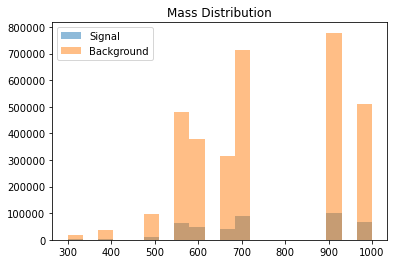

In [12]:
# Mass distribution
import matplotlib.pyplot as plt

plt.hist(signal_df['mass'], bins=20, alpha=0.5, label='Signal')
plt.hist(df_background['mass'], bins=20, alpha=0.5, label='Background')
plt.legend()
plt.title("Mass Distribution")


In [20]:

# class ParameterizedDNN(nn.Module):
#     def __init__(self, input_dim):
#         super(ParameterizedDNN, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.BatchNorm1d(64),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.BatchNorm1d(32),
#             nn.Linear(32, 1)
#         )

#     def forward(self, x):
#         return self.model(x)


In [21]:

# # Example placeholders – REPLACE with actual data loading
# # For demonstration, we simulate signal and background

# np.random.seed(42)
# n_sig, n_bkg = 30000, 3000000
# n_features = 30

# signal = np.random.normal(1, 1, size=(n_sig, n_features))
# background = np.random.normal(0, 1, size=(n_bkg, n_features))

# X = np.vstack([signal, background])
# y = np.array([1]*n_sig + [0]*n_bkg)

# features = [f"f{i}" for i in range(n_features)]  # Placeholder feature names


In [22]:

# # Balance the dataset
# df = pd.DataFrame(X, columns=features)
# df["label"] = y

# signal_df = df[df["label"] == 1]
# background_df = df[df["label"] == 0]

# background_ds = resample(background_df, n_samples=len(signal_df), random_state=42)
# df_balanced = pd.concat([signal_df, background_ds])

# X_bal = df_balanced.drop("label", axis=1).values
# y_bal = df_balanced["label"].values

# X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


In [23]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ParameterizedDNN(X_train.shape[1]).to(device)
# criterion = nn.BCEWithLogitsLoss()
# optimizer = Adam(model.parameters(), lr=0.001)

# model.train()
# for epoch in range(10):
#     epoch_loss = 0
#     y_pred_train, y_true_train = [], []

#     for xb, yb in train_loader:
#         xb, yb = xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         outputs = model(xb).squeeze()
#         loss = criterion(outputs, yb)
#         loss.backward()
#         optimizer.step()

#         probs = torch.sigmoid(outputs).detach().cpu().numpy()
#         y_pred_train.extend(probs)
#         y_true_train.extend(yb.cpu().numpy())
#         epoch_loss += loss.item()

#     auc = roc_auc_score(y_true_train, y_pred_train)
#     acc = accuracy_score(y_true_train, [1 if p > 0.5 else 0 for p in y_pred_train])
#     print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | AUC: {auc:.4f} | Accuracy: {acc:.4f}")


In [24]:

# model.eval()
# with torch.no_grad():
#     test_outputs = model(X_test_tensor.to(device)).squeeze()
#     test_probs = torch.sigmoid(test_outputs).cpu().numpy()

# plt.hist(test_probs[y_test == 1], bins=50, alpha=0.5, label="Signal")
# plt.hist(test_probs[y_test == 0], bins=50, alpha=0.5, label="Background")
# plt.xlabel("Model Output")
# plt.ylabel("Count")
# plt.legend()
# plt.title("Model output distribution on balanced data")
# plt.show()


In [13]:
# ========== Weights ==========
def compute_class_normalized_weights(y):
    signal_mask = y == 1
    background_mask = y == 0

    n_signal = np.sum(signal_mask)
    n_background = np.sum(background_mask)

    weights = np.zeros_like(y, dtype=np.float32)
    weights[signal_mask] = 1.0 / n_signal
    weights[background_mask] = 1.0 / n_background
    weights *= len(y)

    return weights

w_train = compute_class_normalized_weights(y_train)

# ========== Standardization ==========
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ========== Torch Tensors ==========
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
w_train_tensor = torch.tensor(w_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ========== Dataset & DataLoader ==========
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, w_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# ========== Model, Loss, Optimizer ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ParameterizedDNN(X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = Adam(model.parameters(), lr=0.001)

# ========== Training Loop ==========
for epoch in range(10):
    model.train()
    y_pred_train, y_true_train = [], []
    epoch_loss = 0

    for xb, yb, wb in train_loader:
        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)

        optimizer.zero_grad()
        outputs = model(xb).squeeze()
        loss = criterion(outputs, yb)
        weighted_loss = (loss * wb).mean()
        weighted_loss.backward()
        optimizer.step()

        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        y_pred_train.extend(probs)
        y_true_train.extend(yb.cpu().numpy())
        epoch_loss += weighted_loss.item()

    auc = roc_auc_score(y_true_train, y_pred_train)
    acc = accuracy_score(y_true_train, [1 if p > 0.5 else 0 for p in y_pred_train])
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | AUC: {auc:.4f} | Accuracy: {acc:.4f}")

# ========== Evaluation Plot ==========
model.eval()
with torch.no_grad():
    test_probs = torch.sigmoid(model(X_test_tensor.to(device)).squeeze()).cpu().numpy()

plt.hist(test_probs[y_test == 1], bins=50, alpha=0.5, label="Signal")
plt.hist(test_probs[y_test == 0], bins=50, alpha=0.5, label="Background")
plt.xlabel("Model Output")
plt.ylabel("Frequency")
plt.title("Output Distribution on Imbalanced Dataset")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1 | Loss: 355.7630 | AUC: 1.0000 | Accuracy: 0.9969


KeyboardInterrupt: 

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
print("Training Accuracy:", clf.score(X_train, y_train))
print("Testing Accuracy:", clf.score(X_test, y_test))


Training Accuracy: 1.0
Testing Accuracy: 1.0


In [68]:
# Step 1: Correlation with label
import pandas as pd

df_features = pd.DataFrame(X_train, columns=features)
df_features["label"] = y_train

correlations = df_features.corr()["label"].abs().sort_values(ascending=False)
print(correlations)


label                 1.000000
sublead_bjet_eta      0.000187
dibjet_eta            0.000185
lead_pho_phi          0.000168
sublead_bjet_PNetB    0.000148
CosThetaStar_CS       0.000145
mass                  0.000070
CosThetaStar_jj       0.000067
sublead_pho_mvaID     0.000062
dibjet_phi            0.000060
CosThetaStar_gg       0.000060
diphoton_phi          0.000058
lead_bjet_eta         0.000055
sublead_bjet_phi      0.000053
sublead_pho_phi       0.000049
bbgg_phi              0.000043
lead_pho_mvaID        0.000043
pholead_PtOverM       0.000042
DeltaR_jg_min         0.000038
lead_bjet_PNetB       0.000035
lead_bjet_phi         0.000027
phosublead_PtOverM    0.000022
lead_bjet_pt          0.000022
y_value               0.000021
bbgg_eta              0.000019
diphoton_eta          0.000015
sublead_pho_eta       0.000011
sublead_bjet_pt       0.000009
Name: label, dtype: float64


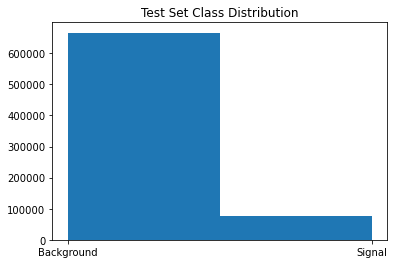

In [55]:
plt.hist(y_test, bins=2)
plt.xticks([0, 1], ['Background', 'Signal'])
plt.title("Test Set Class Distribution")
plt.show()


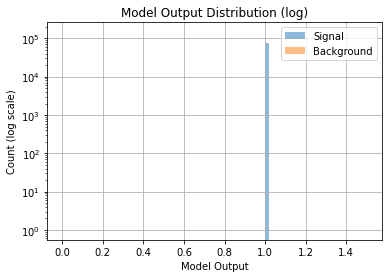

In [56]:
plt.hist(test_probs[y_test == 1], bins=50, alpha=0.5, label="Signal")
plt.hist(test_probs[y_test == 0], bins=50, alpha=0.5, label="Background")
plt.yscale("log")
plt.xlabel("Model Output")
plt.ylabel("Count (log scale)")
plt.legend()
plt.title("Model Output Distribution (log)")
plt.grid(True)
plt.show()
